In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from absl import logging
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from six.moves import range
from sklearn import linear_model
import gin

## The Metric Code

src: https://gitee.com/microcloud/disentanglement_lib

In [ ]:
def _generate_training_sample(ground_truth_data, representation_function,
                              batch_size, random_state, density, repr='VAE', mode='higgins'):
    """Sample a single training sample based on a mini-batch of ground-truth data.

    Args:
      ground_truth_data: GroundTruthData to be sampled from.
      representation_function: Function that takes observation as input and
        outputs a representation.
      batch_size: Number of points to be used to compute the training_sample
      random_state: Numpy random state used for randomness.

    Returns:
      index: Index of coordinate to be used.
      feature_vector: Feature vector of training sample.
    """
    # Select random coordinate to keep fixed.
    index = random_state.randint(ground_truth_data.num_factors)
    # Sample two mini batches of latent variables.
    factors1 = ground_truth_data.sample_factors(batch_size, random_state, density)
    factors2 = ground_truth_data.sample_factors(batch_size, random_state, density)
    
    # Ensure sampled coordinate is the same across pairs of samples.
    factors2[:, index] = factors1[:, index]
    # Transform latent variables to observation space.
    observation1 = ground_truth_data.sample_observations_from_factors(
        factors1, random_state)

    observation2 = ground_truth_data.sample_observations_from_factors(
        factors2, random_state)
    
    # original Dsprites observation shape: obs1:  (5, 64, 64, 1), we need (5, -1) 
    # since input needs to be flattened before passing into encoder
    # print("obs: ", observation1.shape)
    if repr == 'VAE':

      observation1 = torch.permute(torch.tensor(observation1), (0, 3, 1, 2)) # N, C, H, W (originally it was N=5, H=64, W=64, C=1)
      observation2 = torch.permute(torch.tensor(observation2), (0, 3, 1, 2))
      # Compute representations based on the observations.
      with torch.no_grad():
        representation1 = representation_function(observation1)
        representation2 = representation_function(observation2)
      # After encoder, should be of shape (N=5, z*2)

      feature_vector = torch.mean(torch.abs(representation1 - representation2), axis=0) 
    
    if repr == 'PCA':
      observation1 = np.squeeze(observation1, -1).reshape((batch_size, -1)) # N, H*W
      #print("obs1 shape: ", observation1.shape)
      observation2 = np.squeeze(observation2, -1).reshape((batch_size, -1))
      #print("obs2 shape: ", observation2.shape)
      representation1 = representation_function(observation1)
      representation2 = representation_function(observation2)   # out: N, num_pc
      feature_vector = np.mean(np.abs(representation1 - representation2), axis=0)  
    
    if repr == 'BetaVAE':
      observation1 = torch.permute(torch.tensor(observation1), (0, 3, 1, 2)).float() 
      observation2 = torch.permute(torch.tensor(observation2), (0, 3, 1, 2)).float()
      with torch.no_grad():
        representation1 = representation_function(observation1)[0]
        representation2 = representation_function(observation2)[0]
      feature_vector = torch.mean(torch.abs(representation1 - representation2), axis=0) 
      #print("feature vector: ", feature_vector)

    # If we are using this functino for calculating MIG, return representation1, factors1
    if mode == 'MIG':
      return representation1, factors1
    else:
      return index, feature_vector

In [ ]:
def _generate_training_batch(ground_truth_data, representation_function,
                             batch_size, num_points, random_state, density, repr='VAE', mode='higgins'):
    """Sample a set of training samples based on a batch of ground-truth data.

    Args:
      ground_truth_data: GroundTruthData to be sampled from.
      representation_function: Function that takes observations as input and
        outputs a dim_representation sized representation for each observation.
      batch_size: Number of points to be used to compute the training_sample.
      num_points: Number of points to be sampled for training set.
      random_state: Numpy random state used for randomness.

    Returns:
      points: (num_points, dim_representation)-sized numpy array with training set
        features.
      labels: (num_points)-sized numpy array with training set labels.
    """
    
    # If we're using this function for MIG, return encoded_repr, true_factors
    print("mode: ", mode)
    if mode == 'MIG':
      true_factors = []
      encoded_repr = []
      for i in range(num_points):
        encoded, factors = _generate_training_sample(ground_truth_data,\
        representation_function, batch_size, random_state, density, repr, mode='MIG')
        true_factors.append(factors)
        encoded_repr.append(encoded)
      return encoded_repr, true_factors

   # If we're using this function for higgins, return points, labels
    if mode == 'higgins':
      
      points = None # Dimensionality depends on the representation function.
      labels = np.zeros(num_points, dtype=np.int64)
      for i in range(num_points):
          labels[i], feature_vector = _generate_training_sample(
              ground_truth_data, representation_function, batch_size, random_state, density, repr, mode='higgins')
          #print("feature_vector: ", feature_vector.shape, feature_vector)
          if points is None:
              points = np.zeros((num_points, feature_vector.shape[0]))
          points[i, :] = feature_vector
    
      return points, labels

In [ ]:
import torch.nn.functional as F
class linear_metric(nn.Module):
    def __init__(self, inputDim, outputDim=6): # orig: zfeatureDim=32*20*20, Dim=256
      super(linear_metric, self).__init__()
      self.inputDim = inputDim
      self.linear1 = nn.Linear(inputDim, outputDim)
    def forward(self, x):
      x = self.linear1(x)
      x = F.log_softmax(x)
      return x

def train_classifier(model, loss_fn, train_data, labels, optimizer, num_epoch=3):
  for e in range(num_epoch):
    for i, x in enumerate(train_data):
      model.train()
      out = model(x)
      #print("out: ", out)
      #pred = torch.argmax(out).unsqueeze(0).long()
      lab = labels[i].long()
      #print("pred: ", pred, pred.type())
      #print("label: ", lab, lab.type())
      loss = loss_fn(out, lab)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print('Epoch {}: Loss {}'.format(e, loss))
  #return model

In [ ]:
gin.enter_interactive_mode()
@gin.configurable(
    "beta_vae_sklearn",
    denylist=["ground_truth_data", "representation_function", "random_state",
               "artifact_dir"])
def compute_beta_vae_sklearn(ground_truth_data,
                             representation_function,
                             random_state,
                             repr='VAE',
                             artifact_dir=None,
                             batch_size=16,
                             num_train=gin.REQUIRED,
                             num_eval=gin.REQUIRED,
                             clf=linear_model.LogisticRegression,
                             density=1):    
    """Computes the BetaVAE disentanglement metric using scikit-learn.

    Args:
      ground_truth_data: GroundTruthData to be sampled from.
      representation_function: Function that takes observations as input and
        outputs a dim_representation sized representation for each observation.
      random_state: Numpy random state used for randomness.
      artifact_dir: Optional path to directory where artifacts can be saved.
      batch_size: Number of points to be used to compute the training_sample.
      num_train: Number of points used for training.
      num_eval: Number of points used for evaluation.

    Returns:
      Dictionary with scores:
        train_accuracy: Accuracy on training set.
        eval_accuracy: Accuracy on evaluation set.
    """
    del artifact_dir
    print("generating training")
    logging.info("Generating training set.")
    #print("batch size: ", batch_size)
    train_points, train_labels = _generate_training_batch(
        ground_truth_data, representation_function, batch_size, num_train,
        random_state,density, repr)
    
    print("Generated training")
      
    logging.info("Generating evaluation set.")
    eval_points, eval_labels = _generate_training_batch(
        ground_truth_data, representation_function, batch_size, num_eval,
        random_state,density, repr)
    
    logging.info("Training sklearn model.")
    model = clf(random_state=random_state)
    model.fit(train_points, train_labels)

    logging.info("Evaluate training set accuracy.")
    train_accuracy = model.score(train_points, train_labels)
    train_accuracy = np.mean(model.predict(train_points) == train_labels)
    logging.info("Training set accuracy: %.2g", train_accuracy)

    logging.info("Generating evaluation set.")
    print("Generating evaluation")
    eval_points, eval_labels = _generate_training_batch(
        ground_truth_data, representation_function, batch_size, num_eval,
        random_state,density, repr)

    print("Generated evaluation")
    logging.info("Evaluate evaluation set accuracy.")
    eval_accuracy = model.score(eval_points, eval_labels)
    logging.info("Evaluation set accuracy: %.2g", eval_accuracy)
    scores_dict = {}
    scores_dict["beta_vae_train_accuracy"] = train_accuracy
    scores_dict["beta_vae_eval_accuracy"] = eval_accuracy
    return scores_dict

## Mutual Information Gap (MIG) Metric
from [Isolating Sources of Disentanglement in VAEs](https://arxiv.org/abs/1802.04942)

Reference: https://github.com/google-research/disentanglement_lib

In [ ]:
# Mutual Information Gap Metric
from sklearn import metrics

def discretise(l, num_bins):
  # given latents_z[:,i], use np.histogram to get boundaries
  edges = (np.histogram(l, num_bins)[1])[:-1]
  digitized = np.digitize(l, edges)
  return digitized # 1, 2, 3, ...
 
def calculate_entropy(l):
  # note everything's in base e
  return metrics.mutual_info_score(l, l)


# Inputs: true factor and represented latents
# Returns: MIG score
def calculate_mi(true_factors, latents, num_bins=20):
  all_fac_mi = []
  for i, f in enumerate(range(true_factors.shape[1])):
    factor = true_factors[:, i] # n * 1
    print("factor: ", factor.shape)
    # Calculate entropy
    factor_entropy = calculate_entropy(factor)
    print("entropy: ", factor_entropy)
    if factor_entropy == 0: continue
    all_mi = []
    for j, lat in enumerate(range(latents.shape[1])):
      # print("j: ",j)
      latent = latents[:, j] # n * 1
      # print("l: ", latent.shape)
      # Calculate mutual information score
      discretised_latent = discretise(latent, num_bins)
      # print("latent: ",discretised_latent )
      # print("fac: ", factor)
      mi = metrics.mutual_info_score(factor, discretised_latent)
      # print("mi: ", mi)
      all_mi.append(mi)

    sorted_mi = sorted(all_mi, reverse=True)
    print("sorted mi: ", sorted_mi)
    
    # Difference between top 2
    assert len(sorted_mi) > 1
    
    mig = sorted_mi[0] - sorted_mi[1]
    normalised_mig = mig / factor_entropy
    all_fac_mi.append(normalised_mig)
  avg_fac_mi = np.nanmean(all_fac_mi[1:])  # disregard first latent since it's always 0
  print("all_fac_mi: ", all_fac_mi)
  print("avg: ", avg_fac_mi)
  return avg_fac_mi

def get_MI(L, ground_truth_data, representation_function, model_type,\
           num_train_data=2000, density=1, mode="MIG", num_bins=20):
  random_state = np.random.RandomState(0)
  latents, true_factors = _generate_training_batch(
          ground_truth_data, representation_function, L, num_train_data,
          random_state,density, repr=model_type, mode=mode)
  

  latents_z = np.array([res.detach().numpy() if torch.is_tensor(res) else res for res in latents]).squeeze(1)
  factors_x = np.array([res for res in true_factors]).squeeze(1)

  score = calculate_mi(factors_x, latents_z, num_bins)
  return score
  

## Dummy Data and Ground Truth 

In [ ]:
class GroundTruthData(object):
    """Abstract class for data sets that are two-step generative models."""
    tf_format = False
    supervision = True
    @property
    def num_factors(self):
        raise NotImplementedError()

    @property
    def factors_num_values(self):
        raise NotImplementedError()

    @property
    def observation_shape(self):
        raise NotImplementedError()

    def sample_factors(self, num, random_state):
        """Sample a batch of factors Y."""
        raise NotImplementedError()

    def sample_observations_from_factors(self, factors, random_state):
        """Sample a batch of observations X given a batch of factors Y."""
        raise NotImplementedError()

    def sample(self, num, random_state):
        """Sample a batch of factors Y and observations X."""
        factors = self.sample_factors(num, random_state)
        return factors, self.sample_observations_from_factors(factors, random_state)

    def sample_observations(self, num, random_state):
        """Sample a batch of observations X."""
        return self.sample(num, random_state)[1]

    #  Compatible for torch DataSet
    def __len__(self):
        return np.prod(self.factors_num_values)

    def latent_factor(self, index):
        """Get a latent factor from index."""
        factors = np.zeros(
            shape=(1, self.num_factors), dtype=np.int64)
        factors_num_values = self.factors_num_values
        for pos, i in enumerate(factors_num_values):
            num = np.prod(factors_num_values[pos + 1:])
            factors[0, pos] = index // num
            index %= num
        return factors

    def __getitem__(self, item):
        factors = self.latent_factor(item)
        observations = self.sample_observations_from_factors(factors, np.random.RandomState(0))
        return observations.transpose((0, 3, 1, 2))[0].astype(np.float32), factors[0]

In [ ]:
class IdentityObservationsData(GroundTruthData):
    """Data set where dummy factors are also the observations."""

    @property
    def num_factors(self):
        return 10

    @property
    def observation_shape(self):
        return 10

    @property
    def factors_num_values(self):
        return [1] * 10

    def sample_factors(self, num, random_state):
        """Sample a batch of factors Y."""
        return random_state.random_integers(10, size=(num, self.num_factors))

    def sample_observations_from_factors(self, factors, random_state):
        """Sample a batch of observations X given a batch of factors Y."""
        return factors

    @property
    def factor_names(self):
        return ["Factor {}".format(i) for i in range(self.num_factors)]

## Dataset Util

In [ ]:
"""Various utilities used in the data set code."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
from six.moves import range

class SplitDiscreteStateSpace(object):
  """State space with factors split between latent variable and observations."""

  def __init__(self, factor_sizes, latent_factor_indices):
    self.factor_sizes = factor_sizes
    self.num_factors = len(self.factor_sizes) # 6
    self.latent_factor_indices = latent_factor_indices
    self.observation_factor_indices = [
        i for i in range(self.num_factors)
        if i not in self.latent_factor_indices
    ]

  @property
  def num_latent_factors(self):
    return len(self.latent_factor_indices)

  def sample_latent_factors(self, num, random_state, density=1):
    """Sample a batch of the latent factors."""
    factors = np.zeros(
        shape=(num, len(self.latent_factor_indices)), dtype=np.int64)
    for pos, i in enumerate(self.latent_factor_indices):
      factors[:, pos] = self._sample_factor(i, num, random_state, density)
    return factors

  def sample_all_factors(self, latent_factors, random_state):
    """Samples the remaining factors based on the latent factors."""
    num_samples = latent_factors.shape[0]
    #print("num samples: ", num_samples)
    all_factors = np.zeros(
        shape=(num_samples, self.num_factors), dtype=np.int64)
    all_factors[:, self.latent_factor_indices] = latent_factors
    # Complete all the other factors
    for i in self.observation_factor_indices:
      all_factors[:, i] = self._sample_factor(i, num_samples, random_state)
    return all_factors

  def _sample_factor(self, i, num, random_state, density):
    current_factor_size = self.factor_sizes[i]
    if current_factor_size < 30:
        density = 1
    return random_state.randint(np.round(current_factor_size*density), size=num)


class StateSpaceAtomIndex(object):
  """Index mapping from features to positions of state space atoms."""

  def __init__(self, factor_sizes, features):
    """Creates the StateSpaceAtomIndex.
    Args:
      factor_sizes: List of integers with the number of distinct values for each
        of the factors.
      features: Numpy matrix where each row contains a different factor
        configuration. The matrix needs to cover the whole state space.
    """
    self.factor_sizes = factor_sizes
    num_total_atoms = np.prod(self.factor_sizes)
    self.factor_bases = num_total_atoms / np.cumprod(self.factor_sizes)
    feature_state_space_index = self._features_to_state_space_index(features)
    if np.unique(feature_state_space_index).size != num_total_atoms:
      raise ValueError("Features matrix does not cover the whole state space.")
    lookup_table = np.zeros(num_total_atoms, dtype=np.int64)
    lookup_table[feature_state_space_index] = np.arange(num_total_atoms)
    self.state_space_to_save_space_index = lookup_table

  def features_to_index(self, features):
    """Returns the indices in the input space for given factor configurations.
    Args:
      features: Numpy matrix where each row contains a different factor
        configuration for which the indices in the input space should be
        returned.
    """
    state_space_index = self._features_to_state_space_index(features)
    return self.state_space_to_save_space_index[state_space_index]

  def _features_to_state_space_index(self, features):
    """Returns the indices in the atom space for given factor configurations.
    Args:
      features: Numpy matrix where each row contains a different factor
        configuration for which the indices in the atom space should be
        returned.
    """
    if (np.any(features > np.expand_dims(self.factor_sizes, 0)) or
        np.any(features < 0)):
      raise ValueError("Feature indices have to be within [0, factor_size-1]!")
    return np.array(np.dot(features, self.factor_bases), dtype=np.int64)

## Dsprites Data 

src: https://gitee.com/microcloud/disentanglement_lib

In [ ]:
#class DSprites(ground_truth_data.GroundTruthData):
class DSprites(GroundTruthData):
    """DSprites dataset.

    The data set was originally introduced in "beta-VAE: Learning Basic Visual
    Concepts with a Constrained Variational Framework" and can be downloaded from
    https://github.com/deepmind/dsprites-dataset.

    The ground-truth factors of variation are (in the default setting):
    0 - shape (3 different values)
    1 - scale (6 different values)
    2 - orientation (40 different values)
    3 - position x (32 different values)
    4 - position y (32 different values)
    """

    def __init__(self, latent_factor_indices=None):
        # By default, all factors (including shape) are considered ground truth
        # factors.
        if latent_factor_indices is None:
            latent_factor_indices = list(range(6))
        self.latent_factor_indices = latent_factor_indices # [0, 1, 2, 3, 4, 5]
        self.data_shape = [64, 64, 1] # 1 means only 1 channel, since no colour
        # Load the data so that we can sample from it.
        DSPRITES_PATH = '/content/drive/MyDrive/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
        with open(DSPRITES_PATH, "rb") as data_file:
            # Data was saved originally using python2, so we need to set the encoding.
            data = np.load(data_file, encoding="latin1", allow_pickle=True)
            self.images = np.array(data["imgs"])
            print("image size: ", self.images.shape)
            self.factor_sizes = np.array(
                data["metadata"][()]["latents_sizes"], dtype=np.int64)
        self.full_factor_sizes = [1, 3, 6, 40, 32, 32]
        self.factor_bases = np.prod(self.factor_sizes) / np.cumprod(
            self.factor_sizes)
        #self.state_space = util.SplitDiscreteStateSpace(self.factor_sizes,
        #                                                self.latent_factor_indices)


        self.state_space = SplitDiscreteStateSpace(self.factor_sizes,
                                                   self.latent_factor_indices)
    @property
    def num_factors(self):
        return self.state_space.num_latent_factors

    @property
    def factors_num_values(self):
        return [self.full_factor_sizes[i] for i in self.latent_factor_indices]

    @property
    def observation_shape(self):
        return self.data_shape

    def sample_factors(self, num, random_state, density=1):
        """Sample a batch of factors Y."""
        return self.state_space.sample_latent_factors(num, random_state, density)

    def sample_observations_from_factors(self, factors, random_state):
        return self.sample_observations_from_factors_no_color(factors, random_state)

    def sample_observations_from_factors_no_color(self, factors, random_state):
        """Sample a batch of observations X given a batch of factors Y."""
        all_factors = self.state_space.sample_all_factors(factors, random_state)
        #print("all factors: ", all_factors)
        indices = np.array(np.dot(all_factors, self.factor_bases), dtype=np.int64)
        return np.expand_dims(self.images[indices].astype(np.float32), axis=3)

    def _sample_factor(self, i, num, random_state):
        return random_state.randint(self.factor_sizes[i], size=num)



### Load DSprite

#### DSprite as class object

In [ ]:
ds = DSprites() # image size:  (737280, 64, 64)
print(ds.latent_factor_indices) # [0, 1, 2, 3, 4, 5]

image size:  (737280, 64, 64)
[0, 1, 2, 3, 4, 5]


#### DSprite as numpy array

In [ ]:
DSPRITES_PATH = '/content/drive/MyDrive/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
with open(DSPRITES_PATH, "rb") as data_file:
  data = np.load(data_file, encoding="latin1", allow_pickle=True)
  images = data['imgs']

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

In [ ]:
# Initialize a PCA model with 10 latents 
pca = PCA(n_components=15, svd_solver="randomized", whiten=True) 

In [ ]:
# sample a subset (70000 ~8%) of the original dataset to run PCA due to memory limit
num_img = len(images)
rand_ind_small = np.random.randint(0, num_img, 70000)
train_imgs_small = images[rand_ind_small, :] 
print(train_imgs_small.shape)

(70000, 64, 64)


In [ ]:
# Fit PCA
train_imgs_small = train_imgs_small.reshape(train_imgs_small.shape[0], -1)
pca.fit(train_imgs_small)

PCA(n_components=15, svd_solver='randomized', whiten=True)

In [ ]:
# 10 components explain 60.8% of the data as stated in the paper
pca.explained_variance_ratio_.sum()

0.6843325375673037

### PCA Metric Evaluation

In [ ]:
# Run metric 
L = 16
ground_truth_data = ds
representation_function = pca.transform
random_state = np.random.RandomState(0)
scores = compute_beta_vae_sklearn(ground_truth_data, representation_function, random_state, 'PCA', None, L, 2000, 2000)


generating training
mode:  higgins
Generated training
mode:  higgins


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Generating evaluation
mode:  higgins
Generated evaluation


In [ ]:
scores

{'beta_vae_eval_accuracy': 0.524, 'beta_vae_train_accuracy': 0.5735}

In [ ]:
representation_function = pca.transform
# MIG
res_MIG = get_MI(1, ds, representation_function, model_type='PCA', num_train_data=2000, density=1, num_bins=50)


mode:  MIG
factor:  (2000,)
entropy:  0.0
factor:  (2000,)
entropy:  1.098589573243842
sorted mi:  [0.06441722402307648, 0.06173907344958178, 0.05946735501218166, 0.05465381221777643, 0.051706722531970825, 0.05097749154972857, 0.04139628543299864, 0.03948873795347417, 0.03734086124507679, 0.03334473717130666, 0.03286154533297056, 0.032807531002316065, 0.02817021257260978, 0.026951449120381415, 0.02688876526830192]
factor:  (2000,)
entropy:  1.7914736236859397
sorted mi:  [0.2675492282904368, 0.26051047508670255, 0.23492492937359916, 0.22634695349465256, 0.22224394244110207, 0.17110925761494036, 0.154085613786484, 0.13571920700569934, 0.12385573504950609, 0.1206623190876798, 0.09848143220228919, 0.08909149567043796, 0.08508685359395496, 0.08141769500770796, 0.07853209082109963]
factor:  (2000,)
entropy:  3.6805824545065455
sorted mi:  [0.5167332204259356, 0.49859828816302765, 0.48111332808749996, 0.4784648041421956, 0.46507869492110643, 0.46361207132231996, 0.4628444745028796, 0.4625452

## BetaVAEConv
src: https://github.com/jonaswildberger/BetaVAE/blob/main/models/betaVAEConv.py


### Model Setup

In [ ]:
class BetaVAEConv(nn.Module):
  def __init__(self, latent_size=10, beta=1, img_size=(1,64,64)):
    super(BetaVAEConv, self).__init__()
    hidden_channels = 32
    hidden_channels2 = 64
    kernel_size = 4
    hidden_dim = 256
    self.latent_size = latent_size
    self.beta = beta
    num_chan = img_size[0]

    cnn_kwargs = {'stride': 2, "padding": 1}
    self.conv1 = nn.Conv2d(num_chan, hidden_channels, kernel_size, **cnn_kwargs)
    self.conv2 = nn.Conv2d(hidden_channels, hidden_channels2, kernel_size, **cnn_kwargs)
    self.conv3 = nn.Conv2d(hidden_channels2, hidden_channels2, kernel_size, **cnn_kwargs)
    
    self.conv_64 = nn.Conv2d(hidden_channels2, hidden_channels2, kernel_size, **cnn_kwargs)

    self.fc1 = nn.Linear(hidden_channels2 * kernel_size * kernel_size, hidden_dim)
    self.mulogvar = nn.Linear(hidden_dim, self.latent_size * 2)

    self.linear1 = nn.Linear(latent_size, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, hidden_channels * kernel_size * kernel_size)

    self.convT1 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
    self.convT2 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
    self.convT3 = nn.ConvTranspose2d(hidden_channels, num_chan, kernel_size, **cnn_kwargs)
    self.convT_64 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

  def encode(self, input):
    bs = input.shape[0]
    x = torch.relu(self.conv1(input))
    x = torch.relu(self.conv2(x))
    x = torch.relu(self.conv3(x))
    x = torch.relu(self.conv_64(x))

    x = x.view((bs, -1))
    x = torch.relu(self.fc1(x))

    mu_logvar = self.mulogvar(x)
    mu, logvar = mu_logvar.view(-1, self.latent_size, 2).unbind(-1)
    return mu, logvar

  def decode(self, input):
    bs = input.size(0)
    x = torch.relu(self.linear1(input))
    x = torch.relu(self.linear2(x))
    x = torch.relu(self.linear3(x))
    x = x.view(bs, 32, 4, 4)

    x = torch.relu(self.convT_64(x))
    
    x = torch.relu(self.convT1(x))
    x = torch.relu(self.convT2(x))
     # Sigmoid activation for final conv layer
    x = torch.sigmoid(self.convT3(x))
    return x

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps * std + mu
  
  def forward(self, input, **kwargs):
    mu, logvar = self.encode(input)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar
  
  def loss_fn(self, recon, x, mu, log_var):
    bs = x.size(0)
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
    latent_kl = -0.5 * (1 + log_var - mu ** 2 - log_var.exp()).sum(dim=0)
    kld_loss = torch.sum(latent_kl)
    loss = recon_loss + self.beta * kld_loss
    return loss


In [ ]:
"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
def train_conv(num_epoch, train_loader, net, optimizer, device):
  for epoch in range(num_epoch): 
      epoch_loss = 0
      print("epoch: ", epoch)
      for idx, data in enumerate(train_loader):
          net.to(device)
          net.train()
          imgs = data
          imgs = imgs.to(device).float()
          optimizer.zero_grad()
          imgs = imgs.unsqueeze(1)
          #print("img shape: ", imgs.shape)
          # Feeding a batch of images into the network to obtain the output image, mu, and logVar
          recon_batch, mu, logVar = net(imgs)

          # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
          loss = net.loss_fn(recon_batch, imgs, mu,logVar)#/len(data)
          
          # Backpropagation based on the loss
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()

      mean_epoch_loss = epoch_loss / len(train_loader)
      print('Epoch {}: Loss {}'.format(epoch, mean_epoch_loss))

In [ ]:
import matplotlib.pyplot as plt

def recon_samples(samp1_idx, samp2_idx, images, net):
  first = images[samp1_idx]
  print(first.shape)
  first_tensor = torch.tensor(first).float().unsqueeze(0).unsqueeze(0)


  print("first tensor shape: ", first_tensor.shape)
  enc = net.cpu().encode
  dec = net.cpu().decode
  enc_first = enc(first_tensor)[0]
  print("enc_first: ",enc_first.shape)
  #dec_first = dec(enc_first)[0].squeeze(0)
  dec_first = dec(enc_first)#.squeeze(0)
  print("dec_first: ",dec_first.shape)


  last = images[samp2_idx]
  last_tensor = torch.tensor(last).float().unsqueeze(0).unsqueeze(0)

  print("last tensor shape: ", last_tensor.shape)
  enc_last = enc(last_tensor)[0]
  dec_last = dec(enc_last)[0].squeeze(0)

  net.eval()
  with torch.no_grad():
    plt.subplot(221)

    plt.imshow(first)

    plt.subplot(222)
    plt.imshow(last)

    plt.subplot(223)
    plt.imshow(dec_first.squeeze(0).squeeze(0))

    plt.subplot(224)
    plt.imshow(dec_last.squeeze(0).squeeze(0))

  


In [ ]:
"""
dim_to_interpolate = [0-9]
"""
def interpolate(samp_idx, images, net, dim_to_interpolate=0):
  plt.figure(figsize=(10,15))
  plt.gray()
  first = images[samp_idx]
  print(first.shape)
  ## BetaVAE:
  first_tensor = torch.tensor(first).float().unsqueeze(0).unsqueeze(0)
  ## VAE_2d:
  #first_tensor = torch.tensor(first).float().reshape(-1,4096)
  print("first tensor shape: ", first_tensor.shape)
  enc = net.cpu().encode
  enc_first = enc(first_tensor)[0]
  #print("enc_first: ", enc_first, enc_first.shape)
  base_lat = enc_first.repeat((6, 1))

  #print(base_lat)
  first_dim = torch.tensor(np.linspace(-3,3, 6))
  print(first_dim)
  base_lat[:, dim_to_interpolate] = first_dim
  #print(base_lat)

  dec = net.cpu().decode
  ## BetaVAE:
  dec_first = dec(base_lat)#.squeeze(0)
  ## VAE_2d:
  #dec_first = dec_first.reshape(-1, 64,64)


  print(dec_first.shape)

  print(dec_first[0].shape)
  with torch.no_grad():
    
    plt.subplot(161)
    plt.axis('off')
    plt.subplots_adjust(hspace = 1, right = 5)
    plt.imshow(dec_first[0].squeeze(0))


    plt.subplot(162)
    plt.subplots_adjust(hspace = 1, right = 5)
    plt.axis('off')
    plt.imshow(dec_first[1].squeeze(0))

    plt.subplot(163)
    plt.axis('off')
    plt.imshow(dec_first[2].squeeze(0))

    plt.subplot(164)
    plt.axis('off')
    plt.imshow(dec_first[3].squeeze(0))

    plt.subplot(165)
    plt.axis('off')
    plt.imshow(dec_first[4].squeeze(0))

    plt.subplot(166)
    plt.axis('off')
    plt.imshow(dec_first[5].squeeze(0))
  plt.savefig('beta3_plot.png', bbox_inches = 'tight')


In [ ]:
def train_classifier(L, ground_truth_data, representation_function, model_type='BetaVAE', num_train_data=2000, clf=linear_model.LogisticRegression, density=1):
  random_state = np.random.RandomState(0)
  scores = compute_beta_vae_sklearn(ground_truth_data, representation_function, random_state, model_type, None, L, 2000, 2000,clf=clf, density=density)
  return scores

### Train Beta=0.1

In [ ]:
"""
Initialize Hyperparameters
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
learning_rate = 1e-3 #5e-4
num_epochs = 5
beta = 0.1
netConv01 = BetaVAEConv(beta=beta).to(device)
optimizer_netConv01 = torch.optim.Adam(netConv01.parameters(), lr=learning_rate)

In [ ]:
DSPRITES_PATH = '/content/drive/MyDrive/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
with open(DSPRITES_PATH, "rb") as data_file:
  data = np.load(data_file, encoding="latin1", allow_pickle=True)
  images = data['imgs']
  
train_loader_full_conv01 = torch.utils.data.DataLoader(images, batch_size=batch_size, shuffle=True) # each batch: [128, 64, 64]

In [ ]:
train_conv(num_epochs, train_loader_full_conv01, netConv01, optimizer_netConv01, device)

epoch:  0
Epoch 0: Loss 41943.73846299913
epoch:  1
Epoch 1: Loss 7866.530048963758
epoch:  2
Epoch 2: Loss 5954.661558787028
epoch:  3
Epoch 3: Loss 4207.135565270318
epoch:  4
Epoch 4: Loss 3533.3729423099094


(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
enc_first:  torch.Size([1, 10])
dec_first:  torch.Size([1, 1, 64, 64])
last tensor shape:  torch.Size([1, 1, 64, 64])


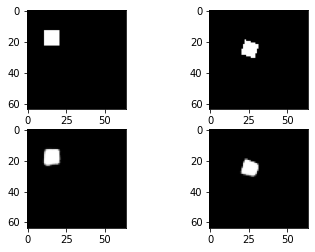

In [ ]:
recon_samples(2, 38217, images, netConv01)

(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
tensor([-3.0000, -1.8000, -0.6000,  0.6000,  1.8000,  3.0000],
       dtype=torch.float64)
torch.Size([6, 1, 64, 64])
torch.Size([1, 64, 64])


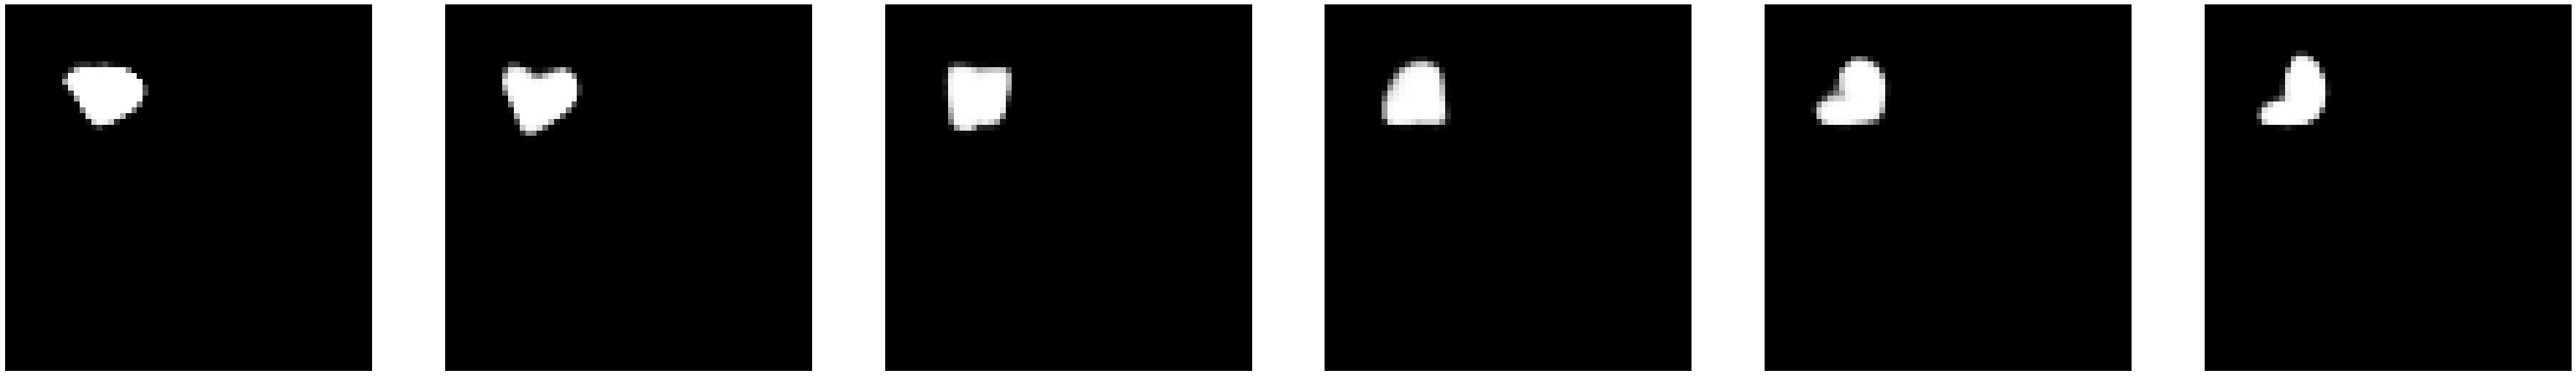

In [ ]:
interpolate(0, images, netConv01, dim_to_interpolate=0)

In [ ]:
representation_function01 = netConv01.cpu().encode


In [ ]:
train_classifier(16, ds, representation_function01, 'BetaVAE', num_train_data=2000)

generating training
mode:  higgins
Generated training
mode:  higgins


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Generating evaluation
mode:  higgins
Generated evaluation


{'beta_vae_eval_accuracy': 0.4865, 'beta_vae_train_accuracy': 0.5215}

In [ ]:
representation_function1 = netConv01.cpu().encode
# MIG
res_MIG = get_MI(1, ds, representation_function1, model_type='BetaVAE', num_train_data=2000, density=1, num_bins=50)


mode:  MIG
factor:  (2000,)
entropy:  0.0
factor:  (2000,)
entropy:  1.098589573243842
sorted mi:  [0.08624603364799693, 0.07214330054305285, 0.060343970528807044, 0.05755948150978372, 0.05754419775532982, 0.05704651975271463, 0.04911006898334689, 0.046380001834164575, 0.04262843964928039, 0.03993576072306226]
factor:  (2000,)
entropy:  1.7914736236859397
sorted mi:  [0.30086072840009764, 0.23942708100917548, 0.19596616846473014, 0.12981793627463178, 0.12854907103610322, 0.11242720969568243, 0.093521218213544, 0.09041786137272832, 0.08910761833300819, 0.0882313091096956]
factor:  (2000,)
entropy:  3.6805824545065455
sorted mi:  [0.5104307453827914, 0.5092268275786294, 0.4941644335513398, 0.47106679799591356, 0.4670582627548521, 0.4664414833081555, 0.46176843685690455, 0.4545395626541125, 0.45079403614400104, 0.44126144456687766]
factor:  (2000,)
entropy:  3.4589834013122136
sorted mi:  [1.0687175700771618, 0.7046717078325104, 0.5846653345483583, 0.4997899257112747, 0.4451829867476864, 

### Train Beta=1

In [ ]:
"""
Initialize Hyperparameters
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
learning_rate = 1e-3 #5e-4
num_epochs = 5
beta = 1
netConv1 = BetaVAEConv(beta=beta).to(device)
optimizer_netConv1 = torch.optim.Adam(netConv1.parameters(), lr=learning_rate)

In [ ]:
DSPRITES_PATH = '/content/drive/MyDrive/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
with open(DSPRITES_PATH, "rb") as data_file:
  data = np.load(data_file, encoding="latin1", allow_pickle=True)
  images = data['imgs']
  
train_loader_full_conv1 = torch.utils.data.DataLoader(images, batch_size=batch_size, shuffle=True) # each batch: [128, 64, 64]

In [ ]:
train_conv(num_epochs, train_loader_full_conv1, netConv1, optimizer_netConv1, device)

epoch:  0
Epoch 0: Loss 39787.03768870036
epoch:  1
Epoch 1: Loss 12131.921321275498
epoch:  2
Epoch 2: Loss 9809.2448832194
epoch:  3
Epoch 3: Loss 7794.184723493788
epoch:  4
Epoch 4: Loss 6728.909245130751


(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
enc_first:  torch.Size([1, 10])
dec_first:  torch.Size([1, 1, 64, 64])
last tensor shape:  torch.Size([1, 1, 64, 64])


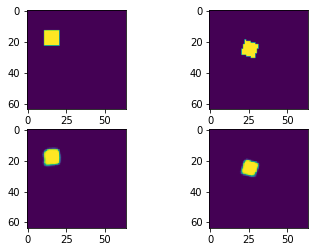

In [ ]:
recon_samples(2, 38217, images, netConv1)

(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
tensor([-3.0000, -1.8000, -0.6000,  0.6000,  1.8000,  3.0000],
       dtype=torch.float64)
torch.Size([6, 1, 64, 64])
torch.Size([1, 64, 64])


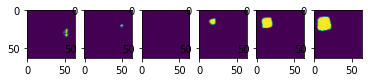

In [ ]:
interpolate(0, images, netConv1, dim_to_interpolate=0)

In [ ]:
representation_function1 = netConv1.cpu().encode


In [ ]:
train_classifier(16, ds, representation_function1, 'BetaVAE', num_train_data=2000)

generating training
mode:  higgins
Generated training
mode:  higgins


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Generating evaluation
mode:  higgins
Generated evaluation


{'beta_vae_eval_accuracy': 0.588, 'beta_vae_train_accuracy': 0.6135}

In [ ]:
# MIG
res_MIG = get_MI(1, ds, representation_function1, model_type='BetaVAE', num_train_data=2000, density=1, num_bins=50)

mode:  MIG
factor:  (2000,)
entropy:  0.0
factor:  (2000,)
entropy:  1.098589573243842
sorted mi:  [0.29908261238291867, 0.28135759629073404, 0.07169439902379429, 0.06599197912777435, 0.06275604008821081, 0.05970851142789429, 0.050168470240726286, 0.04536474690277649, 0.04398209277724001, 0.04359970131575398]
factor:  (2000,)
entropy:  1.7914736236859397
sorted mi:  [0.27827517984076255, 0.17148881135975258, 0.16457924199166052, 0.14036402720660074, 0.13101655796561004, 0.125458221986268, 0.1218909164543826, 0.08741147860448997, 0.07977970895822911, 0.07108199255695388]
factor:  (2000,)
entropy:  3.6805824545065455
sorted mi:  [0.637838958629918, 0.622571020663564, 0.44049776496148785, 0.42813275852399296, 0.42289577739816553, 0.42097899131528704, 0.3639800462206851, 0.3636990370905001, 0.3625713019342306, 0.3412345128437959]
factor:  (2000,)
entropy:  3.4589834013122136
sorted mi:  [1.1118888851612652, 0.5456027117406135, 0.43957800485292303, 0.4083504725989491, 0.39329403126517637, 0

### Train Beta=2

In [ ]:
"""
Initialize Hyperparameters
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
learning_rate = 1e-3 #5e-4
num_epochs = 5
beta = 2
netConv2 = BetaVAEConv(beta=beta).to(device)
optimizer_netConv2 = torch.optim.Adam(netConv2.parameters(), lr=learning_rate)

In [ ]:
train_loader_full_conv2 = torch.utils.data.DataLoader(images, batch_size=batch_size, shuffle=True) # each batch: [128, 64, 64]

In [ ]:
train_conv(num_epochs, train_loader_full_conv2, netConv2, optimizer_netConv2, device)

epoch:  0
Epoch 0: Loss 19683.849011739094
epoch:  1
Epoch 1: Loss 12443.135563659667
epoch:  2
Epoch 2: Loss 11116.745621744793
epoch:  3
Epoch 3: Loss 9783.43475189209
epoch:  4
Epoch 4: Loss 9193.559637620714


(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
enc_first:  torch.Size([1, 10])
dec_first:  torch.Size([1, 1, 64, 64])
last tensor shape:  torch.Size([1, 1, 64, 64])


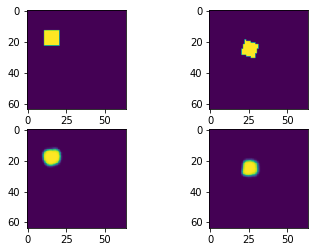

In [ ]:
recon_samples(2, 38217, images, netConv2)

(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
tensor([-3.0000, -1.8000, -0.6000,  0.6000,  1.8000,  3.0000],
       dtype=torch.float64)
torch.Size([6, 1, 64, 64])
torch.Size([1, 64, 64])


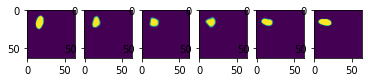

In [ ]:
interpolate(0, images, netConv2, dim_to_interpolate=0)

In [ ]:
representation_function2 = netConv2.cpu().encode
train_classifier(16, ds, representation_function2, 'BetaVAE', num_train_data=2000)

generating training
Generated training


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Generating evaluation
Generated evaluation


{'beta_vae_eval_accuracy': 0.676, 'beta_vae_train_accuracy': 0.716}

In [ ]:
# MIG
representation_function2 = netConv2.cpu().encode
res_MIG = get_MI(1, ds, representation_function2, model_type='BetaVAE', num_train_data=2000, density=1, num_bins=20)

mode:  MIG
factor:  (2000,)
entropy:  0.0
factor:  (2000,)
entropy:  1.098589573243842
sorted mi:  [0.17933485615014677, 0.07391503185760985, 0.053553799406212764, 0.049267202332462186, 0.04594282064855621, 0.041794014691493665, 0.03887359302653704, 0.03322943134360308, 0.028883077380994028, 0.020901250512069508]
factor:  (2000,)
entropy:  1.7914736236859397
sorted mi:  [0.8440632842117602, 0.0989471932210613, 0.08501303480855534, 0.084990730259558, 0.07895914107987065, 0.06018486350863728, 0.05842369440698036, 0.04403788738100889, 0.04078341080703626, 0.03965259557177487]
factor:  (2000,)
entropy:  3.6805824545065455
sorted mi:  [0.2740506133705894, 0.2511817347377821, 0.23796175382628937, 0.23296925470780225, 0.21205522400646112, 0.20936283276743187, 0.20203024294961935, 0.19461108105308952, 0.17535180965571198, 0.17011000139410912]
factor:  (2000,)
entropy:  3.4589834013122136
sorted mi:  [1.039236625236457, 0.9116127335317699, 0.3886000316668492, 0.36551165153995313, 0.298362221603

### Train Beta=3

In [ ]:
"""
Initialize Hyperparameters
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
learning_rate = 1e-3 #5e-4
num_epochs = 5
beta = 1
netConv3 = BetaVAEConv(beta=beta).to(device)
optimizer_netConv3 = torch.optim.Adam(netConv3.parameters(), lr=learning_rate)

In [ ]:
DSPRITES_PATH = '/content/drive/MyDrive/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
with open(DSPRITES_PATH, "rb") as data_file:
  data = np.load(data_file, encoding="latin1", allow_pickle=True)
  images = data['imgs']
  
train_loader_full_conv3 = torch.utils.data.DataLoader(images, batch_size=batch_size, shuffle=True) # each batch: [128, 64, 64]

In [ ]:
train_conv(num_epochs, train_loader_full_conv3, netConv3, optimizer_netConv3, device)

epoch:  0
Epoch 0: Loss 33450.15309651693
epoch:  1
Epoch 1: Loss 12498.015412224664
epoch:  2
Epoch 2: Loss 9916.078112623427
epoch:  3
Epoch 3: Loss 7816.150254567464
epoch:  4
Epoch 4: Loss 6776.4073632982045


(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
enc_first:  torch.Size([1, 10])
dec_first:  torch.Size([1, 1, 64, 64])
last tensor shape:  torch.Size([1, 1, 64, 64])


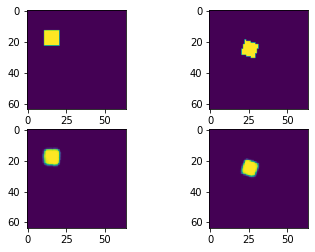

In [ ]:
recon_samples(2, 38217, images, netConv3)

In [ ]:
beta3plot = interpolate(0, images, netConv3, dim_to_interpolate=10)

(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
tensor([-3.0000, -1.8000, -0.6000,  0.6000,  1.8000,  3.0000],
       dtype=torch.float64)


IndexError: ignored

<Figure size 720x1080 with 0 Axes>

In [ ]:
beta3plot.savefig('beta3plot.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
representation_function3 = netConv3.cpu().encode


In [ ]:
train_classifier(16, ds, representation_function3, 'BetaVAE', num_train_data=2000)

generating training
Generated training


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Generating evaluation
Generated evaluation


{'beta_vae_eval_accuracy': 0.7565, 'beta_vae_train_accuracy': 0.7935}

In [ ]:
# MIG
representation_function3 = netConv3.cpu().encode
res_MIG = get_MI(1, ds, representation_function3, model_type='BetaVAE', num_train_data=2000, density=1, num_bins=50)

mode:  MIG
factor:  (2000,)
entropy:  0.0
factor:  (2000,)
entropy:  1.098589573243842
sorted mi:  [0.36584295886492135, 0.28040884242505515, 0.057961244665448435, 0.04227777689976677, 0.03162950884725452, 0.029233831405387916, 0.023825589154577807, 0.020834257962791425, 0.013802735677513568, 0.008818722511382977]
factor:  (2000,)
entropy:  1.7914736236859397
sorted mi:  [0.9898833837854418, 0.09783496673361887, 0.07254074716042658, 0.06007320879132023, 0.05365049875498539, 0.052521171869152464, 0.043972763070050415, 0.03280906520888736, 0.017956562759529716, 0.01600697071386091]
factor:  (2000,)
entropy:  3.6805824545065455
sorted mi:  [0.5335906559080512, 0.10289703270337748, 0.10192540193480297, 0.09653102838033473, 0.08986183425957381, 0.08795110655190694, 0.08634788184911368, 0.08589310691604321, 0.08480862298104566, 0.07562762006087208]
factor:  (2000,)
entropy:  3.4589834013122136
sorted mi:  [1.6575468559251207, 0.6388438417908633, 0.2232341676335187, 0.15060296834051523, 0.115

### Train Beta=4

In [ ]:
"""
Initialize Hyperparameters
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
learning_rate = 1e-3 #5e-4
num_epochs = 5
beta = 4
netConv4 = BetaVAEConv(beta=beta).to(device)
optimizer_netConv4 = torch.optim.Adam(netConv4.parameters(), lr=learning_rate)

In [ ]:
DSPRITES_PATH = '/content/drive/MyDrive/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
with open(DSPRITES_PATH, "rb") as data_file:
  data = np.load(data_file, encoding="latin1", allow_pickle=True)
  images = data['imgs']
  
train_loader_full_conv4 = torch.utils.data.DataLoader(images, batch_size=batch_size, shuffle=True) # each batch: [128, 64, 64]

In [ ]:
train_conv(num_epochs, train_loader_full_conv4, netConv4, optimizer_netConv4, device)

epoch:  0
Epoch 0: Loss 21423.343904113768
epoch:  1
Epoch 1: Loss 16990.248456488716
epoch:  2
Epoch 2: Loss 16727.277729627822
epoch:  3
Epoch 3: Loss 16614.146551513673
epoch:  4
Epoch 4: Loss 16470.993941073946


(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
enc_first:  torch.Size([1, 10])
dec_first:  torch.Size([1, 1, 64, 64])
last tensor shape:  torch.Size([1, 1, 64, 64])


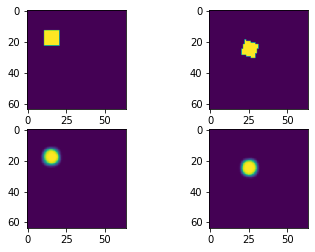

In [ ]:
recon_samples(2, 38217, images, netConv4)

(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
tensor([-3.0000, -1.8000, -0.6000,  0.6000,  1.8000,  3.0000],
       dtype=torch.float64)
torch.Size([6, 1, 64, 64])
torch.Size([1, 64, 64])


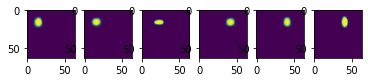

In [ ]:
interpolate(0, images, netConv4, dim_to_interpolate=0)

In [ ]:
representation_function4 = netConv4.cpu().encode
train_classifier(16, ds, representation_function4, 'BetaVAE', num_train_data=2000)

generating training
mode:  higgins
Generated training
mode:  higgins


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Generating evaluation
mode:  higgins
Generated evaluation


{'beta_vae_eval_accuracy': 0.79, 'beta_vae_train_accuracy': 0.805}

In [ ]:
# MIG
res_MIG = get_MI(1, ds, representation_function4, model_type='BetaVAE', num_train_data=2000, density=1, num_bins=50)

mode:  MIG
factor:  (2000,)
entropy:  0.0
factor:  (2000,)
entropy:  1.098589573243842
sorted mi:  [0.47247178219114006, 0.15424087491939992, 0.1321926134647299, 0.12337963530175394, 0.07834801332171239, 0.0747051856436311, 0.0720379835426618, 0.06426023150313619, 0.054520975757437126, 0.04757884232016847]
factor:  (2000,)
entropy:  1.7914736236859397
sorted mi:  [1.1747627124560172, 0.24207031849065505, 0.21264974806736775, 0.2038014701168, 0.195193676847604, 0.17358155029700356, 0.15572826240140253, 0.11343151473048435, 0.11330493723096349, 0.10492524714392237]
factor:  (2000,)
entropy:  3.6805824545065455
sorted mi:  [0.7063004059579172, 0.7050686688711512, 0.6647778532350594, 0.6644949601789016, 0.6521098339967221, 0.5832880745749213, 0.5731255178990187, 0.5717989659708211, 0.543649560214289, 0.5274593978929911]
factor:  (2000,)
entropy:  3.4589834013122136
sorted mi:  [1.7373509702434176, 1.4152202538263314, 0.7036904894943039, 0.6550577324506779, 0.5683059880038995, 0.55850790860



### Train Beta=5

In [ ]:
"""
Initialize Hyperparameters
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
learning_rate = 1e-3 #5e-4
num_epochs = 5
beta = 5
netConv5 = BetaVAEConv(beta=beta).to(device)
optimizer_netConv5 = torch.optim.Adam(netConv5.parameters(), lr=learning_rate)

In [ ]:
DSPRITES_PATH = '/content/drive/MyDrive/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
with open(DSPRITES_PATH, "rb") as data_file:
  data = np.load(data_file, encoding="latin1", allow_pickle=True)
  images = data['imgs']
  
train_loader_full_conv5 = torch.utils.data.DataLoader(images, batch_size=batch_size, shuffle=True) # each batch: [128, 64, 64]

In [ ]:
train_conv(num_epochs, train_loader_full_conv5, netConv5, optimizer_netConv5, device)

epoch:  0
Epoch 0: Loss 23572.09002448188
epoch:  1
Epoch 1: Loss 18130.673868815105
epoch:  2
Epoch 2: Loss 17798.457089572483
epoch:  3
Epoch 3: Loss 17529.39683210585
epoch:  4
Epoch 4: Loss 17076.53977135552


(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
enc_first:  torch.Size([1, 10])
dec_first:  torch.Size([1, 1, 64, 64])
last tensor shape:  torch.Size([1, 1, 64, 64])


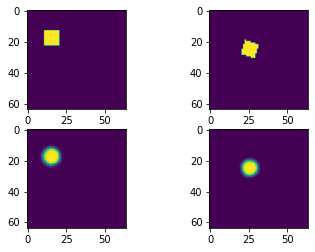

In [ ]:
recon_samples(2, 38217, images, netConv5)

(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
tensor([-3.0000, -1.8000, -0.6000,  0.6000,  1.8000,  3.0000],
       dtype=torch.float64)
torch.Size([6, 1, 64, 64])
torch.Size([1, 64, 64])


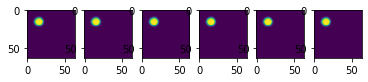

In [ ]:
interpolate(0, images, netConv5, dim_to_interpolate=0)

In [ ]:
representation_function5 = netConv5.cpu().encode
train_classifier(128, ds, representation_function5, 'BetaVAE', num_train_data=2000)

NameError: ignored

In [ ]:
# MIG
representation_function5 = netConv5.cpu().encode
res_MIG = get_MI(1, ds, representation_function5, model_type='BetaVAE', num_train_data=2000, density=1, num_bins=50)

mode:  MIG
factor:  (2000,)
entropy:  0.0
factor:  (2000,)
entropy:  1.098589573243842
sorted mi:  [0.5239373211918632, 0.45935312671675677, 0.36421638453143407, 0.3596449176274033, 0.35857093014364594, 0.35056162046964867, 0.33062185495704677, 0.3123741178955425, 0.044011029238983056, 0.04369267325484609]
factor:  (2000,)
entropy:  1.7914736236859397
sorted mi:  [1.2168213716339609, 0.14734816679618543, 0.13122218585246764, 0.12634303919061302, 0.11472486928972478, 0.11243915002371349, 0.11181069493894946, 0.10110895966672079, 0.07372551796521545, 0.060986835420250754]
factor:  (2000,)
entropy:  3.6805824545065455
sorted mi:  [0.8052567373503815, 0.4630187973824082, 0.462958374119055, 0.4552884832275522, 0.454050183997716, 0.4488075983041519, 0.4415854354972646, 0.4302572924607136, 0.4174663200125216, 0.4060148099435823]
factor:  (2000,)
entropy:  3.4589834013122136
sorted mi:  [2.3863987080575226, 0.38133234116064463, 0.37783138318042725, 0.37550443537155853, 0.36347654885795394, 0.3


### Train Beta=6

In [ ]:
"""
Initialize Hyperparameters
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
learning_rate = 1e-3 #5e-4
num_epochs = 5
beta = 6
netConv6 = BetaVAEConv(beta=beta).to(device)
optimizer_netConv6 = torch.optim.Adam(netConv6.parameters(), lr=learning_rate)

In [ ]:
DSPRITES_PATH = '/content/drive/MyDrive/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
with open(DSPRITES_PATH, "rb") as data_file:
  data = np.load(data_file, encoding="latin1", allow_pickle=True)
  images = data['imgs']
  
train_loader_full_conv6 = torch.utils.data.DataLoader(images, batch_size=batch_size, shuffle=True) # each batch: [128, 64, 64]

In [ ]:
train_conv(num_epochs, train_loader_full_conv6, netConv6, optimizer_netConv6, device)

epoch:  0
Epoch 0: Loss 24013.498750813804
epoch:  1
Epoch 1: Loss 19305.547264607747
epoch:  2
Epoch 2: Loss 18976.50564812554
epoch:  3
Epoch 3: Loss 18854.43152940538
epoch:  4
Epoch 4: Loss 18655.53343166775


(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
enc_first:  torch.Size([1, 10])
dec_first:  torch.Size([1, 1, 64, 64])
last tensor shape:  torch.Size([1, 1, 64, 64])


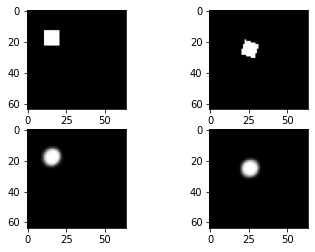

In [ ]:
recon_samples(2, 38217, images, netConv6)

(64, 64)
first tensor shape:  torch.Size([1, 1, 64, 64])
tensor([-3.0000, -1.8000, -0.6000,  0.6000,  1.8000,  3.0000],
       dtype=torch.float64)
torch.Size([6, 1, 64, 64])
torch.Size([1, 64, 64])


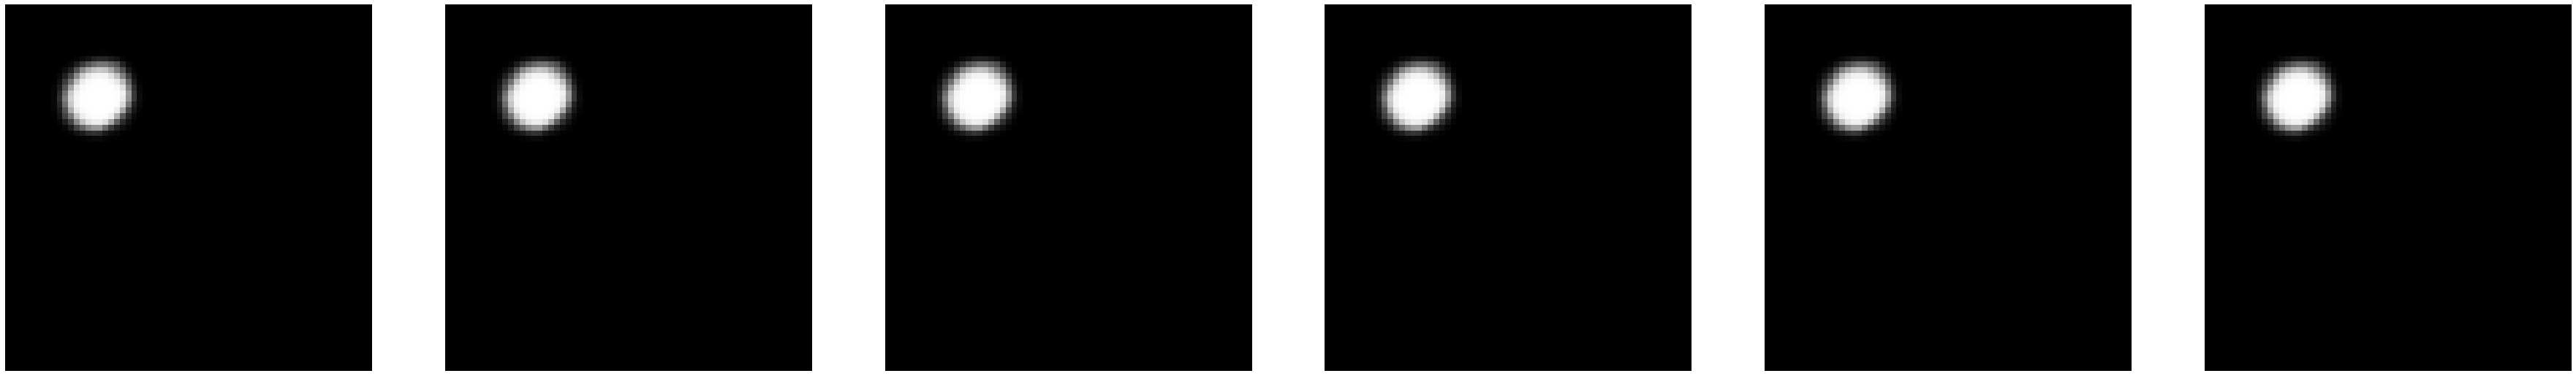

In [ ]:
interpolate(0, images, netConv6, dim_to_interpolate=0)

In [ ]:
representation_function6 = netConv6.cpu().encode
train_classifier(16, ds, representation_function6, 'BetaVAE', num_train_data=2000)

generating training
mode:  higgins
Generated training
mode:  higgins


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Generating evaluation
mode:  higgins
Generated evaluation


{'beta_vae_eval_accuracy': 0.718, 'beta_vae_train_accuracy': 0.7705}

In [ ]:
# MIG
representation_function6 = netConv6.cpu().encode
res_MIG = get_MI(1, ds, representation_function6, model_type='BetaVAE', num_train_data=2000, density=1, num_bins=50)

mode:  MIG
factor:  (2000,)
entropy:  0.0
factor:  (2000,)
entropy:  1.098589573243842
sorted mi:  [0.48228528696266393, 0.10959004878952852, 0.10560883799112714, 0.09544927369644057, 0.07287764373682665, 0.06766219719948179, 0.067242583533425, 0.06322164021430568, 0.06079713184731616, 0.04481094028021242]
factor:  (2000,)
entropy:  1.7914736236859397
sorted mi:  [1.1737114267247073, 0.2794725363872972, 0.15172262637267475, 0.14283664323684678, 0.12101338028088121, 0.11069223553108506, 0.10897667871699578, 0.08223264669006536, 0.0732034149375741, 0.07300905415008307]
factor:  (2000,)
entropy:  3.6805824545065455
sorted mi:  [0.5107144064582785, 0.4992761935099269, 0.4803319113279675, 0.45829305380200674, 0.43843891112716427, 0.4162476305235965, 0.4077668383523881, 0.38955980231538434, 0.3672608329598438, 0.36166190038527435]
factor:  (2000,)
entropy:  3.4589834013122136
sorted mi:  [1.4829217326967628, 1.4755584219962188, 0.5854790401611033, 0.5049256668339378, 0.4569185139477002, 0.44

## Sensitivity Analysis of Metric

sensitivity to the linear classifier used 

### Linear models 

In [ ]:
ridge_scores = train_classifier(16, ds, representation_function1, 'BetaVAE', num_train_data=2000, clf = linear_model.RidgeClassifier)
ridge_scores

In [ ]:
pca_ridge_scores = compute_beta_vae_sklearn(ground_truth_data, representation_function, random_state, 'PCA', None, L, 2000, 2000, clf = linear_model.RidgeClassifier)


In [ ]:
pca_ridge_scores

### Non-Linear Models

In [ ]:
from sklearn import ensemble, neural_network

In [ ]:
grad_boost_scores = train_classifier(16, ds, representation_function4, 'BetaVAE', num_train_data=2000, clf=ensemble.GradientBoostingClassifier)
grad_boost_scores

In [ ]:
pca_gb_scores = compute_beta_vae_sklearn(ground_truth_data, representation_function, random_state, 'PCA', None, L, 2000, 2000, clf = ensemble.GradientBoostingClassifier)


In [ ]:
pca_gb_scores

In [ ]:
rand_forest_scores = train_classifier(16, ds, representation_function4, 'BetaVAE', num_train_data=2000, clf=ensemble.RandomForestClassifier)
rand_forest_scores

In [ ]:
pca_rf_scores = compute_beta_vae_sklearn(ground_truth_data, representation_function, random_state, 'PCA', None, L, 2000, 2000, clf = ensemble.RandomForestClassifier)
pca_rf_scores

In [ ]:
mlp_scores = train_classifier(16, ds, representation_function4, 'BetaVAE', num_train_data=2000, clf=neural_network.MLPClassifier)
mlp_scores

In [ ]:
pca_mlp_scores = compute_beta_vae_sklearn(ground_truth_data, representation_function, random_state, 'PCA', None, L, 2000, 2000, clf = neural_network.MLPClassifier)
pca_mlp_scores

## Sampling Density analysis

In [ ]:
density80 = train_classifier(16, ds, representation_function3, 'BetaVAE', num_train_data=2000, density=0.8)


In [ ]:
density80

In [ ]:
density60 = train_classifier(16, ds, representation_function3, 'BetaVAE', num_train_data=2000, density=0.6)


In [ ]:
density60

In [ ]:
density40 = train_classifier(16, ds, representation_function3, 'BetaVAE', num_train_data=2000, density=0.4)


In [ ]:
density40

## Plot the reconstructed Dsprite

In [ ]:
import matplotlib.pyplot as plt

# Randomly sample a picture
first = images[10]
print(first.shape)
first_tensor = torch.tensor(first).float().unsqueeze(0).unsqueeze(0)


print("first tensor shape: ", first_tensor.shape)
enc = net_VAE.cpu().encoder
dec = net_VAE.cpu().decoder
enc_first = enc(first_tensor)[0]
dec_first = dec(enc_first)[0].squeeze(0)
print("enc_first: ",enc_first.shape)
print("dec_first: ",dec_first.shape)

# Randomly sample another picture
last = images[-180]
last_tensor = torch.tensor(last).float().unsqueeze(0).unsqueeze(0)

print("last tensor shape: ", last_tensor.shape)
enc_last = enc(last_tensor)[0]
dec_last = dec(enc_last)[0].squeeze(0)

net_VAE.eval()
with torch.no_grad():
  plt.subplot(221)
  plt.imshow(first)

  plt.subplot(222)
  plt.imshow(last)

  plt.subplot(223)
  plt.imshow(dec_first)

  plt.subplot(224)
  plt.imshow(dec_last)


## Interpolate between latent space

In [ ]:
# Choose an image to get a latent space
first = images[0]
print(first.shape)
first_tensor = torch.tensor(first).float().unsqueeze(0).unsqueeze(0)

print("first tensor shape: ", first_tensor.shape)
enc = net_VAE.cpu().encoder
encoded_space = enc(first_tensor)[0]

# Get 6 copies of latent representations
base_lat = enc_first.repeat((6, 1))

# get even intervals to interpolate between (-2 to 2)
interval = torch.tensor(np.linspace(-2,2,6))
print(interval)
# Choose a dimension (5) to interpolate, while fixing the other
base_lat[:, 5] = interval
#print(base_lat)

dec = net_VAE.cpu().decoder
dec_first = dec(base_lat)#.squeeze(0)

with torch.no_grad():
  plt.subplot(161)
  plt.imshow(dec_first[0].squeeze(0))

  plt.subplot(162)
  plt.imshow(dec_first[1].squeeze(0))

  plt.subplot(163)
  plt.imshow(dec_first[2].squeeze(0))

  plt.subplot(164)
  plt.imshow(dec_first[3].squeeze(0))

  plt.subplot(165)
  plt.imshow(dec_first[4].squeeze(0))

  plt.subplot(166)
  plt.imshow(dec_first[5].squeeze(0))
